<a href="https://colab.research.google.com/github/Nsharma96/Knowledge-graph-embeddings/blob/master/Graph_ampli_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 1.x
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14
!pip install ampligraph==1.3.2

In [ ]:
import sys,os
from google.colab import drive
drive.mount('/content/drive')

In [2]:
bpath = '/content/drive/My Drive/Stock Data' #datasetdir
sys.path.insert(0,bpath)
os.chdir(bpath)

In [ ]:
import ampligraph
import pandas as pd
import numpy as np
import tensorflow as tf
ampligraph.__version__

In [ ]:
rem = pd.read_csv('tripletsV2.csv')
display(rem.head())
rem['id'] = rem['id'].apply(lambda x: str(x))
x = rem[['id','rel','prop']]
x = x.values
for i in x:
  if len(i)==0:
    print("lenth 0")
x[:5, ]


In [ ]:
entities = np.unique(np.concatenate([x[:, 0], x[:, 2]]))
entities

In [ ]:
relations = np.unique(x[:, 1])
relations

In [17]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train_valid, X_test = train_test_split_no_unseen(x, test_size=3000)
X_train, X_valid = train_test_split_no_unseen(X_train_valid, test_size=3000)
# X_train, X_test = train_test_split_no_unseen(x, test_size=3000)

In [18]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)
print('Validation set size: ', X_valid.shape)

Train set size:  (11241, 3)
Test set size:  (3000, 3)
Validation set size:  (3000, 3)


In [4]:
from ampligraph.latent_features import ComplEx

In [5]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=300, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

In [22]:
positives_filter = x

In [23]:
tf.logging.set_verbosity(tf.logging.ERROR)
# model.fit(X_train, ,early_stopping = True)
model.fit(X_train, early_stopping = True,early_stopping_params = \
                  {
                      'x_valid': X_valid,       # validation set
                      'criteria':'hits10',         # Uses hits10 criteria for early stopping
                      'burn_in': 100,              # early stopping kicks in after 100 epochs
                      'check_interval':20,         # validates every 20th epoch
                      'stop_interval':5,           # stops if 5 successive validation checks are bad.
                      'x_filter': positives_filter,          # Use filter for filtering out positives 
                      'corruption_entities':'all', # corrupt using all entities
                      'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
                  },
          )

Average Loss:   0.039551 — Best validation (hits10): 0.029667:  80%|███████▉  | 239/300 [07:00<01:03,  1.04s/epoch]

In [6]:
from ampligraph.latent_features import save_model, restore_model
# save_model(model, './best_model.pkl')
model = restore_model('./best_model.pkl')
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


In [ ]:
print(X_train)
print(np.__version__)

In [ ]:
from ampligraph.evaluation import evaluate_performance
# X_test = 
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

In [27]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.10
Hits@10: 0.17
Hits@3: 0.11
Hits@1: 0.06


In [ ]:
from scipy.special import expit
X_unseen = X_test[:1000]
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True,
    filter_unseen=True
)
# scores = model.predict(X_unseen)
# probs = expit(scores)
# print(probs)

output = pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen,)) , 
             columns=['statement', 'rank',]).sort_values("rank")

In [ ]:
print(output['rank'].value_counts())

1       279
2        39
3        14
5        11
4         9
       ... 
6583      1
624       1
8571      1
633       1
2447      1
Name: rank, Length: 449, dtype: int64


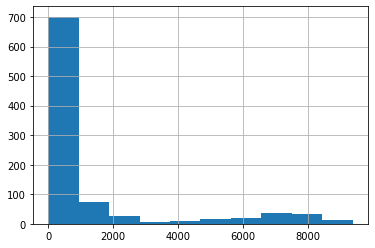

In [ ]:
# output['rank'].hist()

In [ ]:
**************************************end code********************************************

In [8]:
data = pd.read_csv('tripletsV2.csv')
print(data.shape)
data.drop(data[data['name'] == 'no pc_item'].index, inplace=True)
data.drop(data[data['prop'] == 'no price'].index, inplace=True)
print(data.shape)
display(data)

(17241, 4)
(16711, 4)


,id,name,rel,prop
0,24831275,modular office furniture,COLOR,white
1,24831275,modular office furniture,HAS_UNIT,square feet
2,24831275,modular office furniture,HAS_PRICE,600
3,31743796,office furniture,MATERIAL,plywood
4,31743796,office furniture,HAS_UNIT,piece
...,...,...,...,...
17236,138504937,kids red genius group chair,BRAND,ok play
17237,142788282,stainless steel school desk,MATERIAL,stainless steel
17238,142788282,stainless steel school desk,HAS_PRICE,1200
17239,142788282,stainless steel school desk,HAS_UNIT,unit


In [9]:
price_bucket = pd.read_csv('price_bucket.csv')

#Create dictionary for price buckets for mapping.
p_range_map  = dict()
count = 0
for i in range(len(price_bucket['lower'])):
  p_range_map[count] = [price_bucket['lower'].iloc[i],price_bucket['upper'].iloc[i]]
  count+=1

In [ ]:
m = data['id'].apply(lambda x: int(x))
t = (m.unique()).astype(np.int)

display(t)
model.get_embeddings('31743796',embedding_type='entity')

In [65]:
import itertools
pcItem = data['id'].unique()

pcItem_embeddings = dict() 
for i in pcItem:
  # print(type(i))
  pcItem_embeddings[str(i)] = model.get_embeddings(str(i))


# pcItem_embeddings = dict(zip(pcItem,model.get_embeddings(pcItem)))

ke = []
val = []
for k,v in pcItem_embeddings.items():
  ke.append(k)
  val.append(v)
embed_df = pd.DataFrame({'id':ke,'embed':val})

# display(embed_df.head())


price_df = pd.read_csv('item_price2.csv')
price_df.drop(price_df[price_df['id'] == 'no pc_item_id'].index, inplace=True)
price_df.drop(price_df[price_df['price'] == 'no price'].index, inplace=True)
price_df['embed'] = price_df['id'].apply(lambda x: pcItem_embeddings[str(x)])

price_df1 = pd.DataFrame(price_df.embed.values.tolist()).add_prefix('embed_')
price_df1['price'] = price_df['price']
price_df1['id'] = price_df['id']
price_df = price_df1 
# print(price_df.loc[price_df['name'] == 'revolving computer chair'])

price_df.dropna(inplace = True)
# display(price_df)
price_df['price'] = price_df['price'].apply(lambda x: int(x))
#Build target variable
l = []
for i in range(len(price_df['price'])):
    for k,v in p_range_map.items():
      if(price_df['price'].iloc[i]>=v[0] and price_df['price'].iloc[i]<=v[1]):
        l.append(k)
        break
price_df['target'] = l
# price_df['target'] = (price_df.price>4000).astype(int)


display(price_df.head())
display(price_df.describe())
display(embed_df.head())
display(embed_df.describe())
# # print(dict(itertools.islice(pcItem_embeddings.items(), 2)))

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,...,embed_263,embed_264,embed_265,embed_266,embed_267,embed_268,embed_269,embed_270,embed_271,embed_272,embed_273,embed_274,embed_275,embed_276,embed_277,embed_278,embed_279,embed_280,embed_281,embed_282,embed_283,embed_284,embed_285,embed_286,embed_287,embed_288,embed_289,embed_290,embed_291,embed_292,embed_293,embed_294,embed_295,embed_296,embed_297,embed_298,embed_299,price,id,target
0,0.131665,-0.191015,-0.215151,-0.098443,0.208373,0.161720,-0.135725,0.250569,0.108058,0.252687,-0.075333,0.179377,0.102944,-0.077343,0.116895,-0.108122,-0.173083,-0.074281,-0.106742,0.076192,0.115451,0.003143,0.086844,0.002871,-0.012825,-0.014684,-0.195351,0.231556,0.023547,-0.180406,-0.198641,-0.157480,-0.123650,-0.205962,-0.214605,-0.218300,-0.150227,-0.060577,-0.180489,-0.194725,...,0.170761,0.113567,-0.107057,-0.290062,0.175486,0.115064,-0.225529,0.060785,-0.013269,0.189863,0.154077,0.089911,-0.055630,0.193984,0.118469,-0.134651,0.187387,0.173804,0.173580,-0.155550,-0.120504,0.081759,-0.192163,-0.221222,0.123775,-0.155298,-0.138363,-0.168468,-0.223707,-0.167716,-0.195004,0.129837,-0.147810,-0.224396,-0.094494,-0.135530,-0.267081,600,133451114.0,10
1,0.260790,0.122545,0.014134,0.179786,0.109317,0.144864,0.336029,-0.363627,-0.251649,0.122393,0.163102,0.208216,0.078678,-0.253240,-0.079016,0.156038,-0.135676,-0.243905,-0.002282,0.107344,0.291038,-0.320860,0.349066,-0.253826,0.261189,0.292659,-0.232769,0.016502,-0.285644,-0.300823,0.177550,-0.094843,0.171245,-0.089929,-0.222069,0.291596,-0.239384,0.237982,-0.197074,-0.011542,...,-0.059020,-0.291170,-0.377896,-0.255824,0.287054,-0.302437,0.283311,0.277303,0.228433,-0.077001,0.273651,0.317568,-0.066238,0.347763,-0.291032,0.153318,0.158464,0.350033,0.219789,-0.309301,-0.242252,0.076907,0.196107,0.134173,0.170925,0.037567,-0.235562,0.156689,-0.049728,-0.221929,-0.062024,0.213921,-0.218434,-0.169442,-0.173352,0.079016,0.198118,600,104151169.0,10
2,0.028818,0.137877,-0.014346,-0.257535,0.140445,0.047780,0.049795,-0.117826,-0.143277,-0.047116,-0.112376,-0.073321,-0.102951,0.027538,0.142653,-0.138831,-0.156278,-0.072327,-0.178345,0.104220,0.135830,-0.108620,0.110302,-0.088340,-0.064058,-0.139314,0.076482,-0.110864,-0.130797,-0.104554,0.128203,-0.131174,0.112305,-0.183031,-0.051760,0.139713,-0.096380,-0.265929,0.051835,0.086183,...,-0.117333,-0.092659,-0.151555,0.113453,0.050790,0.066245,0.047750,-0.019092,0.093942,0.155416,0.086955,-0.028463,0.092364,0.028192,-0.229127,0.088371,-0.019062,-0.100506,0.114848,0.216073,-0.086541,-0.112133,0.026841,0.078932,0.134841,-0.124983,-0.097842,-0.077703,-0.197326,0.200615,0.136250,0.144839,-0.046054,-0.029978,0.125275,-0.106288,-0.034276,600,126095923.0,10
3,0.214263,-0.161236,-0.166894,0.196322,0.067006,0.147168,0.213985,-0.296227,-0.078796,0.052999,-0.126203,-0.019899,0.193810,-0.241229,0.179335,-0.135375,-0.077069,-0.149207,-0.188833,0.240487,0.111484,-0.121406,0.121496,-0.064648,-0.166334,0.130357,-0.104682,0.155599,-0.331391,-0.214043,-0.154376,-0.176943,-0.112993,0.043001,0.065118,0.101343,-0.217741,0.287278,-0.187450,0.082508,...,0.315942,-0.138366,-0.219103,-0.162443,-0.089588,-0.091313,0.230546,0.204462,0.035974,0.102815,0.236356,0.264019,0.237174,0.294077,-0.108823,0.127666,0.159889,0.144359,0.085038,-0.222447,-0.218637,-0.047708,0.102350,-0.092660,0.140670,-0.163870,-0.014059,-0.279508,-0.107451,0.022499,-0.145111,0.182109,-0.182983,0.215600,-0.147640,-0.043084,0.115775,600,132450480.0,10
4,-0.016052,0.122286,0.043290,0.102077,-0.141009,0.007005,-0.085739,-0.063352,0.134494,-0.003033,0.136838,-0.117113,-0.009654,0.149628,0.073617,-0.100889,0.104585,-0.083718,0.051793,-0.155110,-0.156424,0.091250,0.023525,-0.10

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,...,embed_263,embed_264,embed_265,embed_266,embed_267,embed_268,embed_269,embed_270,embed_271,embed_272,embed_273,embed_274,embed_275,embed_276,embed_277,embed_278,embed_279,embed_280,embed_281,embed_282,embed_283,embed_284,embed_285,embed_286,embed_287,embed_288,embed_289,embed_290,embed_291,embed_292,embed_293,embed_294,embed_295,embed_296,embed_297,embed_298,embed_299,price,id,target
count,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,...,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2551.000000,2.551000e+03,2551.000000
mean,0.049894,0.036295,0.021466,0.020714,-0.041191,0.008657,0.062362,-0.139524,-0.029300,-0.104312,-0.074794,-0.030409,-0.016904,-0.040944,0.029941,-0.007155,0.088660,-0.074613,-0.002513,0.122784,0.022727,-0.068895,-0.014419,0.007664,-0.086178,0.017198,0.031104,-0.083755,-0.142465,-0.024118,0.008500,-0.025695,-0.005689,0.058994,-0.031673,0.062864,0.008050,0.039165,-0.034187,0.126608,...,0.050621,-0.013837,-0.043429,0.037209,-0.023709,0.002772,0.027366,0.038912,0.031638,-0.052890,0.066203,0.056226,0.071365,0.014980,-0.018127,0.092408,-0.016432,-0.013003,-0.012551,-0.043519,-0.083120,-0.066834,0.087368,0.044047,0.049481,0.002491,-0.023235,-0.066873,-0.035152,0.044644,0.065281,0.040390,0.017237,0.116145,-0.032621,0.050813,0.048435,7842.760094,1.216650e+08,18.262642
std,0.158632,0.155884,0.152886,0.180753,0.164446,0.144016,0.159060,0.209616,0.157465,0.158667,0.162137,0.152333,0.147420,0.169828,0.163441,0.166164,0.160091,0.162787,0.164351,0.187346,0.153692,0.187525,0.155269,0.145720,0.160640,0.165017,0.155063,0.144598,0.189669,0.161246,0.150713,0.147167,0.156269,0.210723,0.161939,0.151487,0.151343,0.182211,0.153135,0.190919,...,0.179022,0.161745,0.157166,0.152544,0.152828,0.160291,0.166607,0.188857,0.154887,0.147813,0.163552,0.162474,0.161243,0.167163,0.157100,0.166861,0.150697,0.160437,0.163907,0.171348,0.189915,0.165858,0.147454,0.147434,0.164110,0.165525,0.145694,0.159060,0.166879,0.161321,0.160289,0.150004,0.164497,0.152429,0.186533,0.158439,0.170645,15112.650076,2.911833e+07,5.497237
min,-0.451977,-0.395050,-0.445348,-0.608982,-0.493629,-0.380641,-0.485705,-0.505218,-0.380111,-0.430654,-0.429316,-0.462192,-0.305460,-0.407384,-0.486872,-0.447980,-0.379806,-0.420375,-0.562064,-0.499819,-0.496726,-0.459987,-0.380922,-0.368125,-0.404772,-0.335450,-0.376470,-0.389728,-0.474666,-0.418683,-0.424277,-0.380948,-0.544271,-0.566803,-0.405350,-0.391647,-0.396873,-0.493436,-0.348577,-0.480106,...,-0.385102,-0.446072,-0.410323,-0.468002,-0.394002,-0.392265,-0.468896,-0.654366,-0.344164,-0.406577,-0.392159,-0.449528,-0.568451,-0.446456,-0.373101,-0.567184,-0.385652,-0.349412,-0.462407,-0.453271,-0.464546,-0.401138,-0.495485,-0.408584,-0.500505,-0.440776,-0.359157,-0.507846,-0.578129,-0.431800,-0.439010,-0.395358,-0.334436,-0.382308,-0.403376,-0.487264,-0.433016,0

,id,embed
0,24831275,"[-0.016051525, 0.12228589, 0.043289833, 0.1020..."
1,31743796,"[0.24530408, 0.23720513, -0.15207234, 0.226634..."
2,75451244,"[0.17673334, 0.23182462, -0.1811893, -0.119240..."
3,130141256,"[0.09123515, -0.07816155, -0.16272837, -0.0640..."
4,131623301,"[0.037048396, -0.1583192, 0.13499556, 0.048636..."


,id,embed
count,3611,3611
unique,3611,3611
top,133312689,"[-0.2430539, 0.17562006, 0.0815356, -0.2006737..."
freq,1,1


AxesSubplot(0.125,0.125;0.775x0.755)
       embed_0   embed_1   embed_2  ...   price           id  target
1658  0.099397  0.276180 -0.188720  ...  165550  143123266.0      41
1867  0.004713  0.225716  0.113250  ...  250000  103703976.0      43
1952  0.180056  0.200693 -0.235376  ...  148000  142864666.0      40
1957 -0.125224 -0.191078 -0.008646  ...  277000  142978933.0      44
2849  0.032333 -0.203237 -0.076037  ...  180000  141734561.0      41
2850  0.025802  0.055158  0.176343  ...  180000  140991566.0      41
2851 -0.079365  0.037939  0.175009  ...  180000   64736715.0      41
2966 -0.176613 -0.032991 -0.151015  ...  204050  143122767.0      43
3000  0.222022  0.241578 -0.120458  ...  200000  132307406.0      42
3001 -0.167447 -0.171732 -0.026573  ...  200000  135844126.0      42
3002 -0.194768 -0.196102 -0.050365  ...  200000  145747475.0      42

[11 rows x 303 columns]


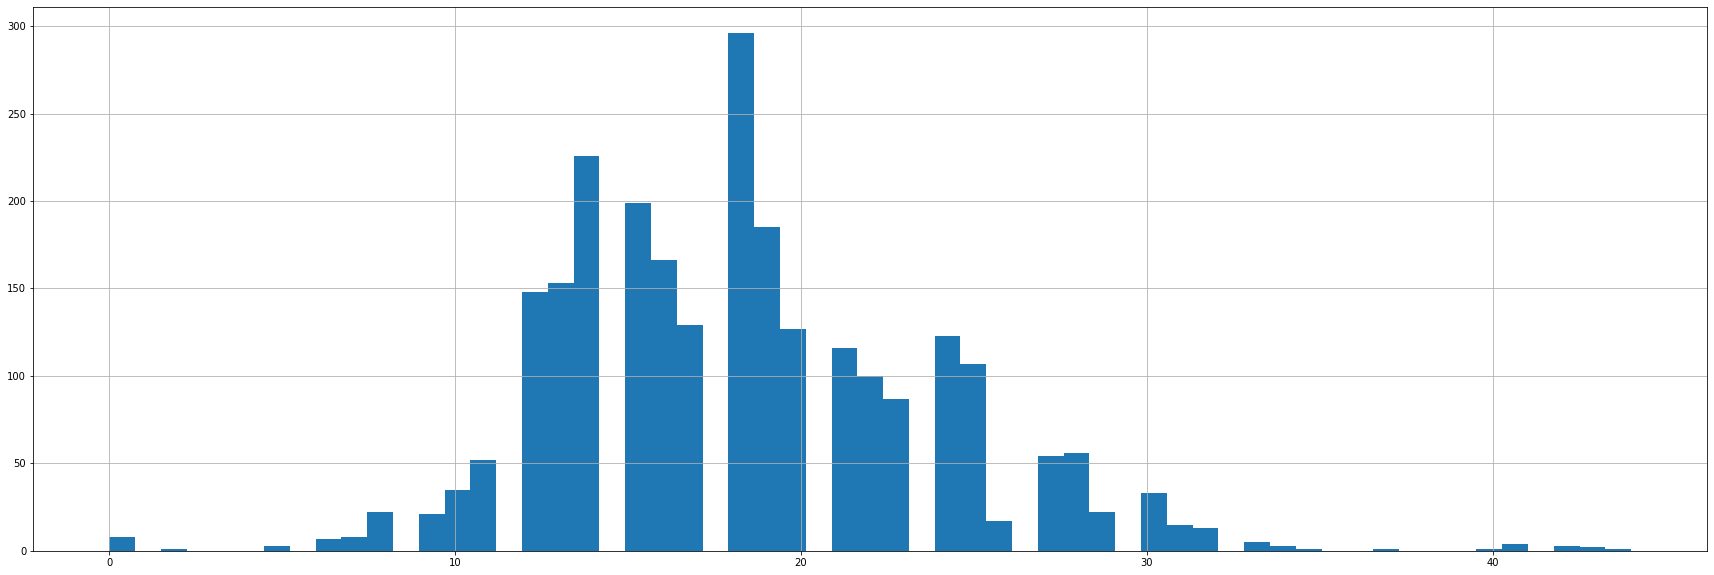

In [47]:
import matplotlib.pyplot as plt
price_df.drop(price_df[price_df['price'] == 0].index, inplace=True)
fig = plt.figure(figsize = (30,10))
ax = fig.gca()
price_df.to_csv('training.csv')
print(price_df['target'].hist(bins=59,ax=ax))
print(price_df[price_df['target']>=40])

In [ ]:
# from sklearn import preprocessing
# lb = preprocessing.LabelBinarizer()
# print(price_df['target'].unique)
# price_df['target_bin'] = lb.fit_transform(price_df['target'].unique)

In [48]:
train_dataset = price_df.sample(frac=0.8,random_state=0)
test_dataset = price_df.drop(train_dataset.index)
train_dataset.pop('price')
test_dataset.pop('price')

0         600
3         600
537      5000
551      5000
554      5000
        ...  
3053     1900
3062     1100
3066     3650
3068    30500
3077     7200
Name: price, Length: 510, dtype: int64

In [49]:
clf_X_train = train_dataset
clf_X_test = test_dataset
y_train = train_dataset.pop('target')
y_test = test_dataset.pop('target')

In [51]:
clf_X_train.shape, clf_X_test.shape
display(clf_X_train)

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,...,embed_261,embed_262,embed_263,embed_264,embed_265,embed_266,embed_267,embed_268,embed_269,embed_270,embed_271,embed_272,embed_273,embed_274,embed_275,embed_276,embed_277,embed_278,embed_279,embed_280,embed_281,embed_282,embed_283,embed_284,embed_285,embed_286,embed_287,embed_288,embed_289,embed_290,embed_291,embed_292,embed_293,embed_294,embed_295,embed_296,embed_297,embed_298,embed_299,id
1088,0.214492,0.197996,0.051320,-0.032535,-0.215699,-0.078820,-0.057796,-0.241964,0.092688,-0.213842,0.112642,0.145876,-0.015596,-0.066006,-0.106557,-0.168402,0.218124,-0.192175,0.051788,0.195586,-0.124247,-0.134480,-0.197265,-0.042506,0.175952,0.224376,-0.228466,-0.141184,0.085735,0.142316,-0.100595,0.173676,-0.221017,0.255516,-0.188088,0.196689,-0.009375,0.035681,-0.162775,0.133508,...,-0.171816,0.261411,0.211148,-0.082577,0.144341,0.183614,0.238767,0.015110,-0.151180,0.167279,-0.205591,-0.227293,-0.151013,-0.126332,-0.069247,-0.126552,0.164592,0.136462,0.083502,-0.025456,-0.121731,-0.286009,0.017669,0.080426,0.178684,0.174673,0.128828,0.233980,0.140396,0.076514,-0.218101,-0.179055,0.085636,-0.057701,0.089523,0.039098,0.052203,0.222763,0.162677,134351172.0
920,0.116948,0.122276,0.203437,0.119665,0.052081,-0.017903,-0.159022,-0.054811,0.209348,0.029326,-0.158418,-0.166142,-0.155731,0.153877,0.209552,-0.133592,0.184283,-0.027573,0.184793,0.085470,0.073212,-0.152641,-0.157118,-0.065984,-0.005574,-0.070689,0.126498,-0.157434,-0.076583,0.080301,0.195356,-0.105669,0.058868,-0.238631,-0.074166,0.032660,0.102479,-0.031858,-0.110988,0.129051,...,0.016693,-0.021849,0.149873,0.126694,-0.125966,0.065587,-0.069426,0.121039,-0.259111,-0.552724,0.089824,-0.132216,0.073721,-0.065862,0.080466,-0.151503,-0.102482,0.135611,0.193818,-0.088449,-0.192060,0.171030,-0.172652,-0.163911,0.126158,0.029092,0.233570,-0.064176,0.058133,-0.076418,-0.041310,-0.151054,0.099940,0.164027,0.202111,0.200243,-0.182040,0.205869,-0.274154,115107478.0
1196,0.105347,0.064592,-0.072747,-0.208226,0.235636,0.091447,0.070069,-0.080022,-0.188009,-0.012207,-0.097866,-0.118546,-0.101348,0.165704,-0.271060,0.442866,-0.021706,-0.076297,-0.471806,0.128276,0.116489,-0.069981,-0.056544,0.065038,-0.071460,-0.210327,0.072480,-0.093235,-0.098979,-0.052559,0.046024,-0.094286,0.036867,-0.453305,-0.089132,0.016171,0.117110,-0.265535,-0.070576,0.084854,...,0.151792,-0.338127,-0.167618,0.346311,-0.190504,-0.029430,-0.023023,0.210117,0.453244,-0.081076,0.041661,0.108247,0.052581,-0.047726,0.077746,0.144082,-0.161192,0.070041,-0.128457,-0.080667,0.102928,-0.072234,-0.039983,-0.111221,0.039599,0.069727,-0.132360,0.384320,-0.039354,0.191653,0.074997,0.383062,0.009946,0.113445,-0.317021,-0.000683,0.407357,-0.161186,-0.186881,134543277.0
1794,0.174789,-0.208137,-0.253369,0.246607,-0.388039,0.224406,0.262009,-0.260932,-0.380111,-0.212790,-0.241979,0.182093,0.360512,0.290499,0.120682,-0.011490,-0.063550,-0.146332,0.199884,0.334003,0.048908,-0.148102,-0.188766,0.227719,-0.244198,-0.198063,0.145684,-0.116315,-0.264968,-0.244937,-0.185503,-0.093431,-0.096878,0.370107,-0.080566,-0.157269,-0.288482,0.055816,-0.119276,-0.052828,...,-0.256774,-0.088379,0.076837,-0.093824,-0.214665,-0.100705,0.146160,-0.298695,-0.009387,0.255990,-0.114050,-0.351798,0.295526,0.086347,0.267197,0.141124,-0.122847,0.238659,0.142519,0.216218,-0.010554,-0.212785,-0.303911,0.047424,0.247612,-0.039531,0.105318,-0.220666,-0.189235,-0.249743,0.137707,0.413983,0.175860,0.213344,0.377753,0.307638,-0.279066,0.074003,-0.277540,105993456.0
2823,-0.016975,0.034848,0.160968,0.222538,-0.262104,0.135771,0.226861,-0.253371,-0.132908,-0.128415,-0.175237,0.131554,-0.029478,0.083737,0.161946,-0.053262,-0.00

In [ ]:
from imblearn.over_sampling import RandomOverSampler,SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
pipeline = Pipeline(steps=[('r', ros), ('u', rus)])
X_resampled, y_resampled = pipeline.fit_resample(clf_X_train.iloc[:,:-1], y_train)

In [ ]:
# temp = pd.DataFrame(X_resampled)
# temp['label'] = y_resampled
# temp['label'].hist(bins=49)

In [53]:
X_resampled.shape, clf_X_test.shape

((8991, 300), (510, 301))

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf = rf.fit(clf_X_train.iloc[:,:-1],y_train)
# rf = rf.fit(X_resampled,y_resampled)
print('rfc trained')

from sklearn.linear_model import LogisticRegression
lrcv = LogisticRegression(random_state=0,verbose=2,max_iter = 500).fit(clf_X_train.iloc[:,:-1], y_train)
# lrcv = LogisticRegression(random_state=0,verbose=2,max_iter = 500).fit(X_resampled, y_resampled)

print('lrcv trained')

from xgboost import XGBClassifier
clf_model = XGBClassifier()
clf_model.fit(clf_X_train.iloc[:,:-1], y_train)
clf_model.fit(X_resampled,y_resampled)
print('Xgboost trained')

from sklearn.ensemble import RandomForestRegressor
# regr = RandomForestRegressor(random_state=0,verbose = 1,criterion = 'mae',n_estimators=20)
# # regr.fit(clf_X_train.iloc[:,:-1], y_train)
# regr.fit(X_resampled,y_resampled)
# print('reger trained')

import xgboost as xgb
# data_dmatrix = xgb.DMatrix(data=clf_X_train.iloc[:,:-1],label=y_train)
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1, n_estimators = 300,verbose = 1,)
# xg_reg.fit(clf_X_train,y_train)

rfc trained


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


lrcv trained
Xgboost trained


In [59]:
# ypred_regr = np.round(regr.predict(clf_X_test.iloc[:,:-1]))
# ypred_xg_reg = np.round(xg_reg.predict(clf_X_test.iloc[:,:-1]))

In [62]:
from sklearn import metrics
# metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))
print(metrics.accuracy_score(y_test, rf.predict(clf_X_test.iloc[:,:-1])))
print(metrics.accuracy_score(y_test, lrcv.predict(clf_X_test.iloc[:,:-1])))
# print(metrics.accuracy_score(y_test, ypred_regr))
# print(metrics.accuracy_score(y_test, ypred_xg_reg))
# print(metrics.accuracy_score(y_test, clf_model.predict(clf_X_test.iloc[:,:-1])))

0.1980392156862745
0.34705882352941175


In [63]:
 lrcv.predict(clf_X_test.iloc[:,:-1])

array([10, 10, 21, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 18,
       13, 15, 18, 17, 16, 19, 21, 18, 22, 13, 19, 16, 20, 19, 12, 19, 18,
       19, 19, 19, 19, 14, 19, 18, 24, 16, 19, 19, 18, 19, 19, 19, 19, 12,
       19, 19, 19, 21, 18, 21, 12, 21, 12, 21, 18, 18, 12, 12, 12, 19, 12,
       12, 12, 18, 21, 18, 18, 14, 24, 18, 15, 18, 18, 13, 13, 18, 12, 25,
       16, 15, 22, 16, 14, 14, 14, 18, 14, 18, 18, 14, 16, 17, 14, 14, 14,
       16, 18, 14, 14, 20, 20, 14, 14, 14, 14, 14, 14, 14, 18, 14, 12, 14,
       18, 14, 14, 18, 14, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 15, 14, 18, 15, 13, 18, 19, 13, 18, 13, 18, 13, 14, 19, 19,
       15, 14, 14, 16, 14, 16, 15, 18, 12, 16, 18, 24, 18, 18, 12, 15, 14,
       13, 13, 19, 13, 13, 14, 13, 18, 13, 15, 18, 13, 18, 14, 18, 13, 24,
       18, 17, 17, 19, 12, 20, 24, 17, 17, 17, 17, 17, 17, 17, 14, 12, 17,
       14, 23, 23, 13, 23, 18, 23, 12, 18, 12, 18, 18, 23, 18, 23, 12, 16,
       31, 18, 11, 16, 25

In [64]:
display(y_test.values)

array([10, 10, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 27, 27, 28,
       28, 28, 17, 17, 17, 17, 17, 17, 17, 17, 17, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 11, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 12, 12, 12, 12, 12,
       12, 12, 12, 15, 15, 15, 15, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 18,
       14, 14, 14, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 12, 12, 12, 24, 24, 24, 24, 19, 19, 19,
       13, 13, 13, 13, 13, 13, 13, 19, 19, 19, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 15,
       23, 23, 23, 23, 23, 23, 23, 12, 12, 12, 12, 12, 12,  0,  0,  0, 31,
       31, 31, 31, 14, 14